# TIM : Detection of points of interest

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
from scipy.ndimage.interpolation import shift

path_base =  './image/'
# source des équations : https://courses.cs.washington.edu/courses/cse576/06sp/notes/HarrisDetector.pdf

<ipython-input-1-5d8ffdedd645>:5: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1- Harris detector - getting started

In the image, some points are distinguished by their intensity compared to their neighborhood indicating a sudden change in the intensity of gray levels and / or the change of orientation of a curve (inflection point or corner). There are several detectors of points of interest. We propose to implement here the Harris detector. This one considers the differences (squared) of intensity around a point and this for all points of the image.


1. Create a 150x150 image with a black square on a white background (chessboard) that you save as a checkboard

Translated with www.DeepL.com/Translator (free version)

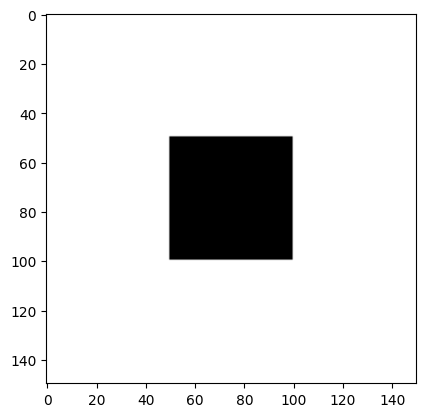

In [3]:
import numpy as np
import cv2

# Create a 150x150 white image
image = np.ones((150, 150), dtype=np.uint8) * 255

# Define the position and size of the black square
square_x = 50
square_y = 50
square_size = 50

# Create a black square on the white background
image[square_y:square_y+square_size, square_x:square_x+square_size] = 0

# Save the image as 'checkerboard.png'
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/TP2/image/checkerboard.png', image)
plt.imshow(image, cmap='gray')
plt.show()


# 2- Harris algorithm

The principle of Harris is to calculate the changes of intensity in the image in all directions. Three situations arise from the calculation of the energy E

- Situation 1: The intensity is approximately constant in the image area considered: the function E will then take low values in all directions (x, y).
- Situation 2 : The considered image area contains a rectilinear contour : the E function will then take low values for displacements (x,y) along the contour and high values for displacements perpendicular to the contour.
- Situation 3: The considered image area contains a corner or an isolated point (point of interest): the E function will take strong values in all directions.

The calculation of the values according to the directions is done naturally by calculating the directional derivatives in each pixel.

2. Calculate the derivatives Ix and Iy of the image


Translated with www.DeepL.com/Translator (free version)

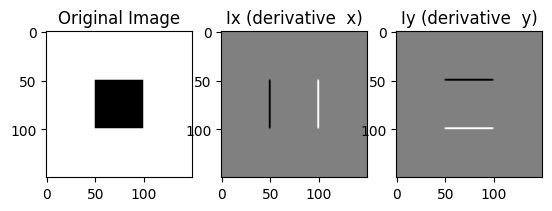

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/TP2/image/checkerboard.png', cv2.IMREAD_GRAYSCALE)

Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(Ix, cmap='gray'), plt.title('Ix (derivative  x)')
plt.subplot(133), plt.imshow(Iy, cmap='gray'), plt.title('Iy (derivative  y)')
plt.show()


3. Calculate (elementwise)

\begin{equation*}
    a = (\frac{dI}{dx})^{2}
\end{equation*}

\begin{equation*}
    b = (\frac{dI}{dx})\dot(\frac{dI}{dy})
\end{equation*}


\begin{equation*}
    c = (\frac{dI}{dy})^{2}
\end{equation*}


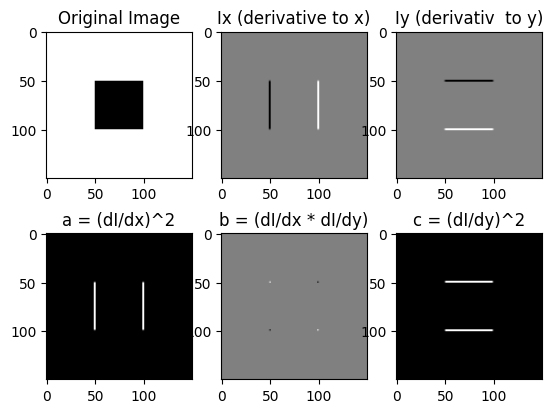

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/TP2/image/checkerboard.png', cv2.IMREAD_GRAYSCALE)

Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
a = Ix**2
b = Ix * Iy
c = Iy**2

plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(Ix, cmap='gray'), plt.title('Ix (derivative to x)')
plt.subplot(233), plt.imshow(Iy, cmap='gray'), plt.title('Iy (derivativ  to y)')
plt.subplot(234), plt.imshow(a, cmap='gray'), plt.title('a = (dI/dx)^2')
plt.subplot(235), plt.imshow(b, cmap='gray'), plt.title('b = (dI/dx * dI/dy)')
plt.subplot(236), plt.imshow(c, cmap='gray'), plt.title('c = (dI/dy)^2')
plt.show()


# Harris R operator
4. Calculate lambda 1 and lambda 2 the principal axes of the E ellipse for each pixel.

In [6]:
# Code here
import cv2
import numpy as np
from matplotlib import pyplot as plt

H = np.array([[a, b], [b, c]])

lambda1, lambda2 = np.linalg.eigvals(H[0, 0, :, :]), np.linalg.eigvals(H[1, 1, :, :])

# Convert eigenvalues to 2D arrays
lambda1_2d = np.expand_dims(lambda1, axis=0)
lambda2_2d = np.expand_dims(lambda2, axis=0)


5. Plot the images lamda 1 and lamda 2. What do you think?

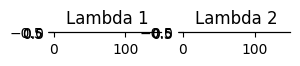

In [7]:
# Display lambda1 and lambda2
plt.subplot(247), plt.imshow(lambda2_2d, cmap='gray'), plt.title('Lambda 1')
plt.subplot(248), plt.imshow(lambda2_2d, cmap='gray'), plt.title('Lambda 2')
plt.show()

6. Compute the Harris R operator with 0.04 < k <0.06

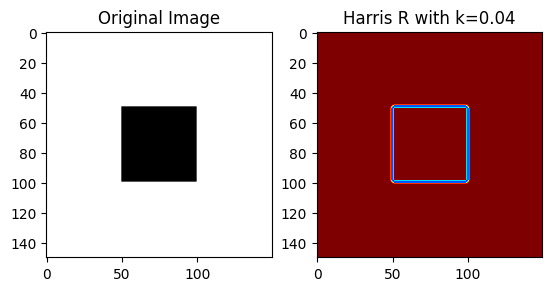

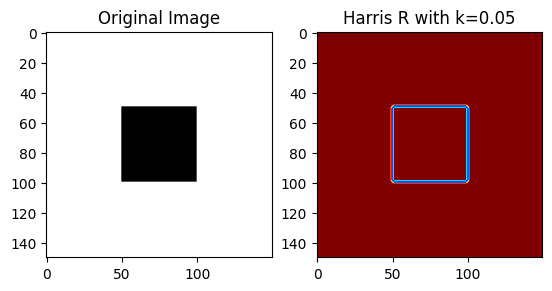

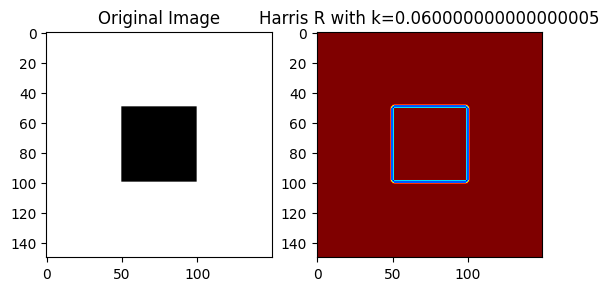

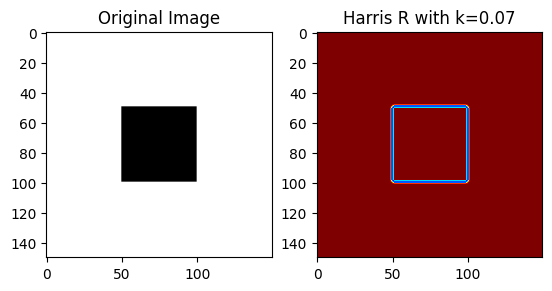

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('checkerboard.png', cv2.IMREAD_GRAYSCALE)

Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)


# Harris response matrix H
alpha = 0.04  # Harris corner detector constant (adjust as needed)
trace_H = a + c
det_H = a * c - b**2
lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

# Calculate Harris R operator for different values of k
k_values = np.arange(0.04, 0.07, 0.01)
for k in k_values:
    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2
        # Display the original image and R
    plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
    plt.subplot(122), plt.imshow(R, cmap='jet'), plt.title(f'Harris R with k={k}')

    plt.show()

7. Plot the image R

8. Create a function that takes as input the original image and gives as output the image R = Harris_Oprator(img)

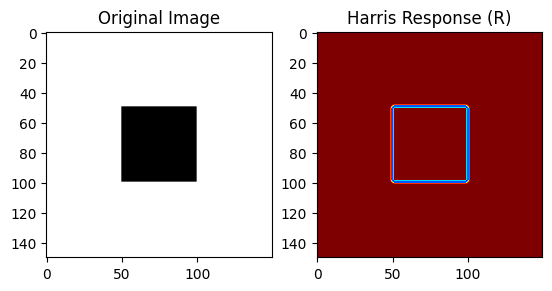

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_operator(img, k=0.04):
    # Calculate the derivatives Ix and Iy using Sobel operators
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
    a = Ix**2
    b = Ix * Iy
    c = Iy**2

    # Harris response matrix H
    trace_H = a + c
    det_H = a * c - b**2
    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    # Calculate Harris R operator
    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    return R

# Load the checkerboard image (assuming you've created it in the previous step)
image = cv2.imread('checkerboard.png', cv2.IMREAD_GRAYSCALE)

# Apply the Harris operator function
harris_response = harris_operator(image)

# Display the original image and the computed Harris response
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(harris_response, cmap='jet'), plt.title('Harris Response (R)')
plt.show()


# 3- Detection of points of interest

The points of interest are the pixels for which R>0 (R<0 : contour, abs(R) very small: homogeneous area)

9. Choose the threshold t of your choice on the image R to detect the most salient points of interest.

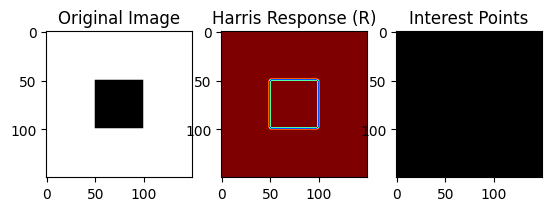

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_operator(img, k=0.04):
    # Calculate the derivatives Ix and Iy using Sobel operators
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
    a = Ix**2
    b = Ix * Iy
    c = Iy**2

    # Harris response matrix H
    trace_H = a + c
    det_H = a * c - b**2
    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    # Calculate Harris R operator
    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    return R

def detect_interest_points(R, threshold):
    # Detect points of interest based on the threshold
    interest_points = np.where(R > threshold, 255, 0).astype(np.uint8)

    return interest_points

# Load the checkerboard image (assuming you've created it in the previous step)
image = cv2.imread('checkerboard.png', cv2.IMREAD_GRAYSCALE)

# Apply the Harris operator function
harris_response = harris_operator(image)

# Set the threshold for detecting points of interest
threshold = 0.01  # Adjust this threshold as needed

# Detect points of interest based on the threshold
interest_points = detect_interest_points(harris_response, threshold)

# Display the original image, Harris response, and detected interest points
plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(harris_response, cmap='jet'), plt.title('Harris Response (R)')
plt.subplot(133), plt.imshow(interest_points, cmap='gray'), plt.title('Interest Points')
plt.show()


10. Correct your function to have another function Harris_Corner_Detector(img, N) that outputs the points of interest directly on the image img where N is the number of points of interest to detect.

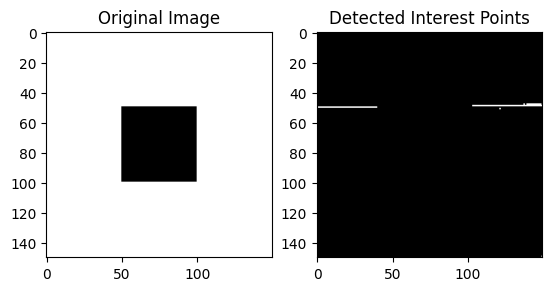

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_corner_detector(img, N=100, k=0.04):
    # Calculate the derivatives Ix and Iy using Sobel operators
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
    a = Ix**2
    b = Ix * Iy
    c = Iy**2

    # Harris response matrix H
    trace_H = a + c
    det_H = a * c - b**2
    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    # Calculate Harris R operator
    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    # Sort the R values in descending order and get corresponding indices
    indices = np.argsort(R.ravel())[::-1][:N]

    # Create an image to mark detected points
    interest_points = np.zeros_like(img, dtype=np.uint8)
    interest_points.flat[indices] = 255

    return interest_points

# Load the checkerboard image (assuming you've created it in the previous step)
image = cv2.imread('checkerboard.png', cv2.IMREAD_GRAYSCALE)

# Apply the Harris corner detector function with a specified number of points (N)
N_points = 100  # Adjust this value as needed
interest_points_image = harris_corner_detector(image, N_points)

# Display the original image and the detected interest points
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(interest_points_image, cmap='gray'), plt.title('Detected Interest Points')
plt.show()

# 3 - Application
11. Apply your function on the image lena_gray.tif with 50 points of interest detected

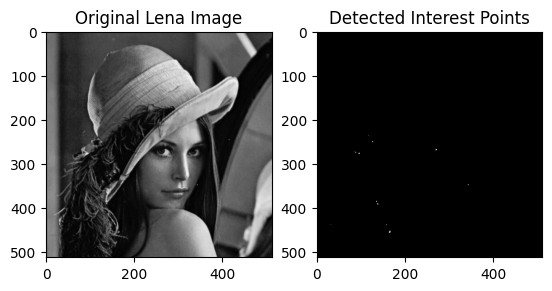

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_corner_detector(img, N=100, k=0.04):

    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
    a = cv2.GaussianBlur(Ix**2, (5, 5), 0)
    b = cv2.GaussianBlur(Ix * Iy, (5, 5), 0)
    c = cv2.GaussianBlur(Iy**2, (5, 5), 0)

    # Harris response matrix H
    trace_H = a + c
    det_H = a * c - b**2
    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    indices = np.argsort(R.ravel())[::-1][:N]

    interest_points = np.zeros_like(img, dtype=np.uint8)
    interest_points.flat[indices] = 255

    return interest_points

# Replace this with the absolute path to your "lena_gray.tif" image
lena_gray_path = '/content/drive/MyDrive/Colab Notebooks/TP2/image/lena_gray.tif'
lena_gray = cv2.imread(lena_gray_path, cv2.IMREAD_GRAYSCALE)

# Apply the Harris corner detector function with 50 points of interest
N_points = 50
interest_points_image = harris_corner_detector(lena_gray, N_points)

# Display the original image and the detected interest points
plt.subplot(121), plt.imshow(lena_gray, cmap='gray'), plt.title('Original Lena Image')
plt.subplot(122), plt.imshow(interest_points_image, cmap='gray'), plt.title('Detected Interest Points')
plt.show()


12. Repeat the same process by filtering A, B and C by a

*   Élément de liste
*   Élément de liste

Gaussian filter of size 5x5. Is the detection result improved ?


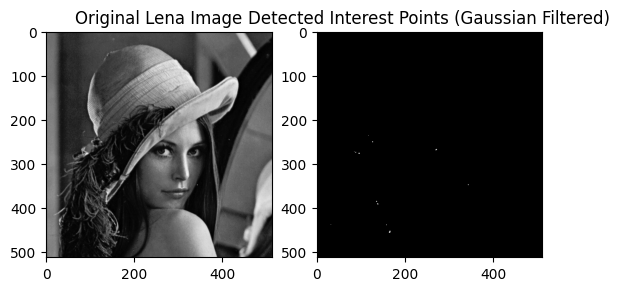

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_corner_detector(img, N=100, k=0.04):
    # Calculate the derivatives Ix and Iy using Sobel operators
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate elementwise a = (dI/dx)^2, b = (dI/dx * dI/dy), c = (dI/dy)^2
    a = Ix**2
    b = Ix * Iy
    c = Iy**2

    # Apply Gaussian filter to a, b, and c
    a = cv2.GaussianBlur(a, (5, 5), 0)
    b = cv2.GaussianBlur(b, (5, 5), 0)
    c = cv2.GaussianBlur(c, (5, 5), 0)

    # Harris response matrix H
    trace_H = a + c
    det_H = a * c - b**2
    lambda1 = 0.5 * (trace_H + np.sqrt(trace_H**2 - 4 * det_H))
    lambda2 = 0.5 * (trace_H - np.sqrt(trace_H**2 - 4 * det_H))

    # Calculate Harris R operator
    R = lambda1 * lambda2 - k * (lambda1 + lambda2)**2

    # Sort the R values in descending order and get corresponding indices
    indices = np.argsort(R.ravel())[::-1][:N]

    # Create an image to mark detected points
    interest_points = np.zeros_like(img, dtype=np.uint8)
    interest_points.flat[indices] = 255

    return interest_points

# Replace this with the absolute path to your "lena_gray.tif" image
lena_gray_path = '/content/drive/MyDrive/Colab Notebooks/TP2/image/lena_gray.tif'
lena_gray = cv2.imread(lena_gray_path, cv2.IMREAD_GRAYSCALE)

# Apply the Harris corner detector function with 50 points of interest after Gaussian filtering
N_points = 50
interest_points_image = harris_corner_detector(lena_gray, N_points)

# Display the original image and the detected interest points after Gaussian filtering
plt.subplot(121), plt.imshow(lena_gray, cmap='gray'), plt.title('Original Lena Image')
plt.subplot(122), plt.imshow(interest_points_image, cmap='gray'), plt.title('Detected Interest Points (Gaussian Filtered)')
plt.show()


# Bonus
13. Incorporate in your function the NMS: a filter of size 7x7 sliding on the image R which allows to choose the pixel having the maximum value.

In [14]:
# Code here
